<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip
# !unzip /content/FullAndFracture.zip
# !rm FullAndFracture.zip

In [3]:
!gdown 1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE

Downloading...
From: https://drive.google.com/uc?id=1AIQPe2G6ZHPwZLmo19-ewbqCNT7TDfYE
To: /content/FullAndFracture.npy
100% 466M/466M [00:02<00:00, 162MB/s]


In [4]:
data = np.load('FullAndFracture.npy')
data.shape  #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [5]:
X = data[1] #fracturado
Y = data[0] #completo

In [6]:
def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z] >= 0.5:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  if len(points) < 1: return
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

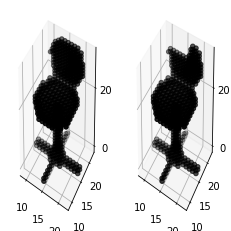

In [7]:
#@title Visualizar {run: "auto"}
id = 283 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN3D - Pytorch

In [8]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [9]:
torch.manual_seed(0)

In [10]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid, pos )

In [11]:
#@title Bloque de Convolución 
class ConvBlock(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""
  # def __init__(self, in_channels, out_channels, mid_channels=None):
  #   super().__init__()
  #   if not mid_channels:
  #     mid_channels = out_channels
  #   self.double_conv = nn.Sequential(
  #     nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(mid_channels),
  #     nn.ReLU(inplace=True),
  #     nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
  #     nn.BatchNorm3d(out_channels),
  #     nn.ReLU(inplace=True)
  #   )
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
      nn.BatchNorm3d(out_channels),
      nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    return self.double_conv(x)

In [12]:
#@title Discriminador (Encoder)
class Discriminator(nn.Module):
  """Downscaling """
  
  class Down(nn.Module):
    """[Block] Downscaling with AvgPool then double conv"""
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
        nn.AvgPool3d(kernel_size = 2),
        ConvBlock(in_channels, out_channels)
      )
    def forward(self, x):
      return self.maxpool_conv(x)

  def __init__(self, trilinear=True):
    super(Discriminator, self).__init__()
    self.inc = ConvBlock(1, 32)      #32^3
    self.down1 = self.Down(32, 64)    #16^3
    self.down2 = self.Down(64, 128)   #8^3
    self.down3 = self.Down(128, 256)  #4^3
    self.factor = 2 if trilinear else 1
    self.down4 = self.Down(256, 512 // self.factor)

  def forward(self, x):
    x = self.inc(x)
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.down4(x)
    return x

In [13]:
#@title Generador (UNet)
class Generator(Discriminator):
  """Downscaling + Upscaling"""
  
  class Up(nn.Module):
    """[Block] Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, trilinear=True):
      super().__init__()
      # if trilinear, use the normal convolutions to reduce the number of channels
      if trilinear:
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels) #, in_channels // 2
      else:
        self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)
    
  def __init__(self, trilinear=True):
    super(Generator, self).__init__(trilinear)
    self.up1 = self.Up(512, 256 // self.factor, trilinear)
    self.up2 = self.Up(256, 128 // self.factor, trilinear)
    self.up3 = self.Up(128, 64 // self.factor, trilinear)
    self.up4 = self.Up(64, 32, trilinear)
    self.outc = ConvBlock(32, 1)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

### Funciones de Pérdida

In [14]:
def get_gen_loss(gen, disc, criterion, incomplete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [15]:
def get_disc_loss(gen, disc, criterion, incomplete, complete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(complete)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

# Guardar modelo

In [16]:
from google.colab import drive #, files
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
folder = '/gdrive/MyDrive/UPC-CC/6. Machine Learning/ADAM' #@param {type:'string'}

In [18]:
def save_model(n): #, download:bool = False
  torch.save(disc.state_dict(), f'{folder}/disc_{n}.pth')
  torch.save(gen.state_dict(), f'{folder}/gen_{n}.pth')
  # if download:
  #   files.download(f'{folder}/gen_{n}.pth')
  #   files.download(f'{folder}/disc_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

In [19]:
def load_model(n, model_type:str = 'gen'):
  """ model_type options: 'gen' | 'disc' """
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # disc = torch.load(f'{folder}/disc_{n}.pth')
  # disc.eval()
  gen = Generator() if model_type=='gen' else Discriminator()
  gen.load_state_dict(torch.load(f'{folder}/{model_type}_{n}.pth', map_location = device))
  return gen.eval()

# Entrenar

**Dataset**

In [ ]:
size = (32,32,32)
# original shape (num_objs, 32, 32, 32)
# shape must be [num_objs, n_channels, depth,height,width]
X = X.reshape( X.shape[0], 1, *size )
Y = Y.reshape( Y.shape[0], 1, *size )

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [ ]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [ ]:
n_epochs = 400
save_epoch = 10 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 96
lr = 0.00001

In [ ]:
criterion = nn.L1Loss() #.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Crear o Cargar Modelo
# Step 10000: Generator loss: 0.6930094504356386, discriminator loss: 0.6051261096000671
# Epoch 192: Generator loss: 0.04850963485240936, discriminator loss: 0.042283251881599426
# disc_24.pth and gen_24.pth were saved.
new_models = False #@param {type: 'boolean'}
if new_models:
  gen = Generator().to(device)
  disc = Discriminator().to(device)
else:
  last_n_saved = "19" #@param {type:'string'}
  gen = load_model(last_n_saved, 'gen').to(device)
  disc = load_model(last_n_saved, 'disc').to(device)

In [ ]:
# gen_opt = optim.RMSprop(gen.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
gen_opt = optim.Adam(gen.parameters(), lr=lr)
# disc_opt = optim.RMSprop(disc.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
disc_opt = optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step+1
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  for epoch in range(last_epoch+1,n_epochs):
    for incomplete, complete in tqdm(dataloader):
      cur_batch_size = len(complete)
      complete = complete.to(device=device, dtype=torch.float32)
      incomplete = incomplete.to(device=device, dtype=torch.float32)
      #Loss
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, incomplete, complete, cur_batch_size, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, incomplete, cur_batch_size, device)
      gen_loss.backward()
      gen_opt.step()
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      #Display
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        fake = gen(incomplete)
        show_tensor_images(incomplete, size, 1)
        show_tensor_images(fake, size, 2)
        show_tensor_images(complete, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    print(f"Epoch {epoch} | Step:{cur_step} \t Generator loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}" )
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)

In [ ]:
train(last_step=0, last_epoch=0)

In [ ]:
train(last_step=0, last_epoch=0)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 0 | Step:52 	 Generator loss: 0.06678547227382658, Discriminator loss: 0.054370588779449454


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 | Step:104 	 Generator loss: 0.13047760951519013, Discriminator loss: 0.10634928292036053


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 | Step:156 	 Generator loss: 0.19414515209198005, Discriminator loss: 0.15823325848579398


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 | Step:208 	 Generator loss: 0.2578914036750794, Discriminator loss: 0.2100862884521484


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 | Step:260 	 Generator loss: 0.3219698414802551, Discriminator loss: 0.2618467497229575


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 | Step:312 	 Generator loss: 0.3864989117383957, Discriminator loss: 0.3134280427694318


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 | Step:364 	 Generator loss: 0.4518021422624588, Discriminator loss: 0.36477793735265723


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 | Step:416 	 Generator loss: 0.5176792366504668, Discriminator loss: 0.4157028712630272


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 | Step:468 	 Generator loss: 0.5843934687376022, Discriminator loss: 0.4661098656058313


  0%|          | 0/52 [00:00<?, ?it/s]

Step 500: 	 Generator loss: 0.6267836515903471, Discriminator loss: 0.49798774224519743
Epoch 9 | Step:520 	 Generator loss: 0.024411672234535223, Discriminator loss: 0.018272165417671207


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 | Step:572 	 Generator loss: 0.09163913536071777, Discriminator loss: 0.06799660652875901


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_1.pth and gen_1.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 | Step:624 	 Generator loss: 0.15932080805301668, Discriminator loss: 0.11727040827274327


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 | Step:676 	 Generator loss: 0.22733894288539885, Discriminator loss: 0.166100840330124


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 | Step:728 	 Generator loss: 0.29584632039070113, Discriminator loss: 0.21454988068342218


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 | Step:780 	 Generator loss: 0.3651761422157286, Discriminator loss: 0.2626094845533371


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 | Step:832 	 Generator loss: 0.4351611897945401, Discriminator loss: 0.3104395597577097


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 | Step:884 	 Generator loss: 0.5056212730407712, Discriminator loss: 0.35813460856676116


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 | Step:936 	 Generator loss: 0.5758786782026291, Discriminator loss: 0.4058901804685595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 | Step:988 	 Generator loss: 0.645947934985161, Discriminator loss: 0.4536664874553683


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1000: 	 Generator loss: 0.6633573387861252, Discriminator loss: 0.465744108617306
Epoch 19 | Step:1040 	 Generator loss: 0.05234611606597899, Discriminator loss: 0.036027827858924874


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 | Step:1092 	 Generator loss: 0.12235418629646301, Discriminator loss: 0.0839489567279816


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_2.pth and gen_2.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 | Step:1144 	 Generator loss: 0.1924852540493011, Discriminator loss: 0.1318830176591873


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 | Step:1196 	 Generator loss: 0.26264107668399794, Discriminator loss: 0.17978645509481433


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 | Step:1248 	 Generator loss: 0.33278355109691576, Discriminator loss: 0.2277840726971626


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 | Step:1300 	 Generator loss: 0.40301291024684854, Discriminator loss: 0.2757353131175041


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 | Step:1352 	 Generator loss: 0.47348534214496574, Discriminator loss: 0.323590078175068


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 | Step:1404 	 Generator loss: 0.5442969493865961, Discriminator loss: 0.3712820419669153


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 | Step:1456 	 Generator loss: 0.615283704400062, Discriminator loss: 0.4188479486107829


  0%|          | 0/52 [00:00<?, ?it/s]

Step 1500: 	 Generator loss: 0.6765157370567316, Discriminator loss: 0.46021905261278184
Epoch 28 | Step:1508 	 Generator loss: 0.009518527507781982, Discriminator loss: 0.006423209965229035


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 | Step:1560 	 Generator loss: 0.08009848821163175, Discriminator loss: 0.0544555597305298


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 | Step:1612 	 Generator loss: 0.15101545882225034, Discriminator loss: 0.10216629970073698


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_3.pth and gen_3.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 | Step:1664 	 Generator loss: 0.2223047207593917, Discriminator loss: 0.14983376079797747


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 | Step:1716 	 Generator loss: 0.2934429126977919, Discriminator loss: 0.19749847996234887


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 | Step:1768 	 Generator loss: 0.36461215066909763, Discriminator loss: 0.2452148106098174


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 | Step:1820 	 Generator loss: 0.4361001552343365, Discriminator loss: 0.29277203464508034


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 | Step:1872 	 Generator loss: 0.5076659927368162, Discriminator loss: 0.3402515015006063


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 | Step:1924 	 Generator loss: 0.579345577359199, Discriminator loss: 0.38765480655431717


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 | Step:1976 	 Generator loss: 0.6510953122377392, Discriminator loss: 0.4350390700697894


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2000: 	 Generator loss: 0.6854934413433073, Discriminator loss: 0.4579079935550685
Epoch 38 | Step:2028 	 Generator loss: 0.037433149576187125, Discriminator loss: 0.024473158955574028


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 | Step:2080 	 Generator loss: 0.10888612580299378, Discriminator loss: 0.07217285305261613


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 | Step:2132 	 Generator loss: 0.18067705607414247, Discriminator loss: 0.11950546944141391


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_4.pth and gen_4.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 | Step:2184 	 Generator loss: 0.252733726143837, Discriminator loss: 0.16674366712570193


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 | Step:2236 	 Generator loss: 0.32477070546150183, Discriminator loss: 0.21401195180416113


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 | Step:2288 	 Generator loss: 0.3968636425733567, Discriminator loss: 0.2611965354681017


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 | Step:2340 	 Generator loss: 0.4690855020284652, Discriminator loss: 0.3083688690662386


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 | Step:2392 	 Generator loss: 0.5415860484838484, Discriminator loss: 0.3552948278784752


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 | Step:2444 	 Generator loss: 0.6133477536439893, Discriminator loss: 0.4028317586779595


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 | Step:2496 	 Generator loss: 0.6859672569036481, Discriminator loss: 0.44967861396074305


  0%|          | 0/52 [00:00<?, ?it/s]

Step 2500: 	 Generator loss: 0.6929737613201139, Discriminator loss: 0.4541702153086663
Epoch 48 | Step:2548 	 Generator loss: 0.06532307767868045, Discriminator loss: 0.04265120100975037


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 | Step:2600 	 Generator loss: 0.1377565521001816, Discriminator loss: 0.08968218266963958


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 | Step:2652 	 Generator loss: 0.21021886551380164, Discriminator loss: 0.13679387557506562


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_5.pth and gen_5.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 51 | Step:2704 	 Generator loss: 0.2829190974235535, Discriminator loss: 0.18386264890432366


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 52 | Step:2756 	 Generator loss: 0.3558379839658737, Discriminator loss: 0.23064058417081837


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 53 | Step:2808 	 Generator loss: 0.42854677140712727, Discriminator loss: 0.27754028493165983


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 54 | Step:2860 	 Generator loss: 0.5015671919584275, Discriminator loss: 0.324261920809746


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 55 | Step:2912 	 Generator loss: 0.5745891402959824, Discriminator loss: 0.37093277335166946


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 56 | Step:2964 	 Generator loss: 0.6476272413730619, Discriminator loss: 0.41785566884279274


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3000: 	 Generator loss: 0.6993971624374387, Discriminator loss: 0.45128931474685685
Epoch 57 | Step:3016 	 Generator loss: 0.020894852995872494, Discriminator loss: 0.013598295927047728


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 58 | Step:3068 	 Generator loss: 0.09309896612167357, Discriminator loss: 0.06106711399555207


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 59 | Step:3120 	 Generator loss: 0.16583614122867585, Discriminator loss: 0.10804293674230575


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 60 | Step:3172 	 Generator loss: 0.2387304909229279, Discriminator loss: 0.1549906562566757


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_6.pth and gen_6.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 61 | Step:3224 	 Generator loss: 0.3115358337163925, Discriminator loss: 0.20199579900503156


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 62 | Step:3276 	 Generator loss: 0.3852023513317107, Discriminator loss: 0.24848010385036462


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 63 | Step:3328 	 Generator loss: 0.4584219324588773, Discriminator loss: 0.29507913553714754


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 64 | Step:3380 	 Generator loss: 0.5315221773385999, Discriminator loss: 0.34193571013212204


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 65 | Step:3432 	 Generator loss: 0.6047783460617067, Discriminator loss: 0.3886975687742235


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 66 | Step:3484 	 Generator loss: 0.6782851852178575, Discriminator loss: 0.4352179742455484


  0%|          | 0/52 [00:00<?, ?it/s]

Step 3500: 	 Generator loss: 0.7021186952590944, Discriminator loss: 0.45050145047903073
Epoch 67 | Step:3536 	 Generator loss: 0.049182327389717104, Discriminator loss: 0.031612193644046785


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 68 | Step:3588 	 Generator loss: 0.12248200333118445, Discriminator loss: 0.07834816008806227


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 69 | Step:3640 	 Generator loss: 0.19613976407051092, Discriminator loss: 0.12462312757968896


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 70 | Step:3692 	 Generator loss: 0.2693589169979097, Discriminator loss: 0.17144260883331294


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_7.pth and gen_7.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 71 | Step:3744 	 Generator loss: 0.34307728111743935, Discriminator loss: 0.2178807500600814


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 72 | Step:3796 	 Generator loss: 0.41682462263107295, Discriminator loss: 0.2641937053203583


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 73 | Step:3848 	 Generator loss: 0.48974777328968044, Discriminator loss: 0.31108723330497745


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 74 | Step:3900 	 Generator loss: 0.5628054523468019, Discriminator loss: 0.35807381772994984


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 75 | Step:3952 	 Generator loss: 0.6366872948408127, Discriminator loss: 0.40432123804092385


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4000: 	 Generator loss: 0.7063195248842242, Discriminator loss: 0.4479334508180615
Epoch 76 | Step:4004 	 Generator loss: 0.0043231468200683595, Discriminator loss: 0.0026214997172355654


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 77 | Step:4056 	 Generator loss: 0.07837222492694856, Discriminator loss: 0.0487118552327156


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 78 | Step:4108 	 Generator loss: 0.15197181630134587, Discriminator loss: 0.09535361635684965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 79 | Step:4160 	 Generator loss: 0.2262242220640182, Discriminator loss: 0.1413991110324859


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4212 	 Generator loss: 0.30036994922161103, Discriminator loss: 0.18750596249103535


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4264 	 Generator loss: 0.3737696261405946, Discriminator loss: 0.2341766977906226


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4316 	 Generator loss: 0.44810914695262893, Discriminator loss: 0.28021482580900176


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4368 	 Generator loss: 0.5223353545665742, Discriminator loss: 0.3263841091990469


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4420 	 Generator loss: 0.5961464560031895, Discriminator loss: 0.37286714047193503


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 85 | Step:4472 	 Generator loss: 0.6704649758338933, Discriminator loss: 0.41890594989061314


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.7119087358713152, Discriminator loss: 0.44457593405246687
Epoch 86 | Step:4524 	 Generator loss: 0.032909751653671264, Discriminator loss: 0.0203499156832695


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 | Step:4576 	 Generator loss: 0.10695199918746949, Discriminator loss: 0.06650678002834319


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4628 	 Generator loss: 0.18133579111099246, Discriminator loss: 0.11260627740621565


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4680 	 Generator loss: 0.25511993336677546, Discriminator loss: 0.15893632024526588


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4732 	 Generator loss: 0.3296570883989335, Discriminator loss: 0.20498961067199706


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4784 	 Generator loss: 0.40427709686756147, Discriminator loss: 0.2508923869132995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4836 	 Generator loss: 0.47879236912727385, Discriminator loss: 0.29679379653930643


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 80 | Step:4264 	 Generator loss: 0.10042173123359675, Discriminator loss: 0.05932919263839721
disc_8.pth and gen_8.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 81 | Step:4316 	 Generator loss: 0.2043191175460815, Discriminator loss: 0.11088251554965968


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 82 | Step:4368 	 Generator loss: 0.30831909883022307, Discriminator loss: 0.16176754868030535


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 83 | Step:4420 	 Generator loss: 0.4123190882205963, Discriminator loss: 0.21229671865701671


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 84 | Step:4472 	 Generator loss: 0.5163190580606463, Discriminator loss: 0.2626244229674339


  0%|          | 0/52 [00:00<?, ?it/s]

Step 4500: 	 Generator loss: 0.5743190356492999, Discriminator loss: 0.29064632946252816
Epoch 85 | Step:4524 	 Generator loss: 0.04599992060661317, Discriminator loss: 0.022184318363666532


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 86 | Step:4576 	 Generator loss: 0.14999982297420508, Discriminator loss: 0.07220899122953417


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 87 | Step:4628 	 Generator loss: 0.2539995667934418, Discriminator loss: 0.12200067162513736


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 88 | Step:4680 	 Generator loss: 0.35799948108196256, Discriminator loss: 0.17150868058204657


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 89 | Step:4732 	 Generator loss: 0.4619992346763611, Discriminator loss: 0.22066228586435319


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 90 | Step:4784 	 Generator loss: 0.5659987246990205, Discriminator loss: 0.2694329161643982
disc_9.pth and gen_9.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 91 | Step:4836 	 Generator loss: 0.6699983659982683, Discriminator loss: 0.31789504456520085


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 92 | Step:4888 	 Generator loss: 0.7739969718456273, Discriminator loss: 0.36589481371641175


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 93 | Step:4940 	 Generator loss: 0.8770169727802283, Discriminator loss: 0.41607060855627076


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 94 | Step:4992 	 Generator loss: 0.9803734946250917, Discriminator loss: 0.46797594553232197


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5000: 	 Generator loss: 0.9983163985013963, Discriminator loss: 0.4769469608664512
Epoch 95 | Step:5044 	 Generator loss: 0.08566452634334562, Discriminator loss: 0.04287583196163178


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 96 | Step:5096 	 Generator loss: 0.18918638193607323, Discriminator loss: 0.09470002675056456


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 97 | Step:5148 	 Generator loss: 0.292686314344406, Discriminator loss: 0.14649938064813622


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 98 | Step:5200 	 Generator loss: 0.39617829477787003, Discriminator loss: 0.19827917718887336


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 99 | Step:5252 	 Generator loss: 0.49967680048942553, Discriminator loss: 0.25005042552948


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 100 | Step:5304 	 Generator loss: 0.603123296737671, Discriminator loss: 0.3018125337958337
disc_10.pth and gen_10.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 101 | Step:5356 	 Generator loss: 0.7065097267627715, Discriminator loss: 0.3535608323812486


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 102 | Step:5408 	 Generator loss: 0.8098192062377932, Discriminator loss: 0.4052817758321763


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 103 | Step:5460 	 Generator loss: 0.9131207685470584, Discriminator loss: 0.45697815549373616


  0%|          | 0/52 [00:00<?, ?it/s]

Step 5500: 	 Generator loss: 0.9945618393421176, Discriminator loss: 0.49772166347503655
Epoch 104 | Step:5512 	 Generator loss: 0.02184606325626373, Discriminator loss: 0.010928918600082396


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 105 | Step:5564 	 Generator loss: 0.12507656526565553, Discriminator loss: 0.06256822705268861


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 106 | Step:5616 	 Generator loss: 0.22819982302188882, Discriminator loss: 0.11415538811683655


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 107 | Step:5668 	 Generator loss: 0.33124710869789126, Discriminator loss: 0.16568562257289876


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 108 | Step:5720 	 Generator loss: 0.4342010837793349, Discriminator loss: 0.21715589380264272


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 109 | Step:5772 	 Generator loss: 0.5370920389890671, Discriminator loss: 0.26861704474687564


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 110 | Step:5824 	 Generator loss: 0.6398645482063294, Discriminator loss: 0.32008791506290435
disc_11.pth and gen_11.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 111 | Step:5876 	 Generator loss: 0.7425306115150452, Discriminator loss: 0.3715327600240709


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 112 | Step:5928 	 Generator loss: 0.8450374076366425, Discriminator loss: 0.42291466188430793


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 113 | Step:5980 	 Generator loss: 0.9474522664546965, Discriminator loss: 0.4742397714853287


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6000: 	 Generator loss: 0.988780559539795, Discriminator loss: 0.49495069521665574
Epoch 114 | Step:6032 	 Generator loss: 0.06098606812953949, Discriminator loss: 0.03055411064624786


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 115 | Step:6084 	 Generator loss: 0.16325575375556947, Discriminator loss: 0.08178982478380205


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 116 | Step:6136 	 Generator loss: 0.26541636645793903, Discriminator loss: 0.13297388237714772


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 117 | Step:6188 	 Generator loss: 0.36742223513126365, Discriminator loss: 0.18406686693429955


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 118 | Step:6240 	 Generator loss: 0.4693870635032652, Discriminator loss: 0.2351199935078622


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 119 | Step:6292 	 Generator loss: 0.5713614405393599, Discriminator loss: 0.2861552344560623


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 120 | Step:6344 	 Generator loss: 0.6731825437545773, Discriminator loss: 0.33710409981012346
disc_12.pth and gen_12.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121 | Step:6396 	 Generator loss: 0.7749464340209958, Discriminator loss: 0.38798834913969044


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122 | Step:6448 	 Generator loss: 0.8767117216587063, Discriminator loss: 0.4388541963100434


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 123 | Step:6500 	 Generator loss: 0.9784430606365196, Discriminator loss: 0.4896904489398004


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: 	 Generator loss: 0.9803993054628365, Discriminator loss: 0.4906659531593324
Epoch 124 | Step:6552 	 Generator loss: 0.09969290602207184, Discriminator loss: 0.04981914830207826


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 125 | Step:6604 	 Generator loss: 0.2013192139863968, Discriminator loss: 0.10056311428546906


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126 | Step:6656 	 Generator loss: 0.3029347904920579, Discriminator loss: 0.15131182110309593


  0%|          | 0/52 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

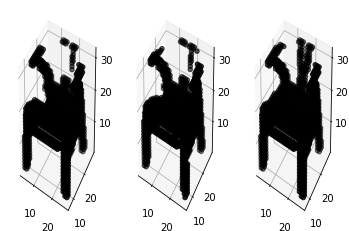

In [ ]:
train(last_step=4212, last_epoch=80)

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 121 | Step:6397 	 Generator loss: 0.1020182683467865, Discriminator loss: 0.051077727258205405


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 122 | Step:6449 	 Generator loss: 0.2034802978038788, Discriminator loss: 0.10189183974266054


  0%|          | 0/52 [00:00<?, ?it/s]

Step 6500: 	 Generator loss: 0.3047503396272659, Discriminator loss: 0.15266020405292519
Epoch 123 | Step:6501 	 Generator loss: 0, Discriminator loss: 0


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 124 | Step:6553 	 Generator loss: 0.10052492332458497, Discriminator loss: 0.05051009452342987


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 125 | Step:6605 	 Generator loss: 0.2003855011463165, Discriminator loss: 0.1006145745515823


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 126 | Step:6657 	 Generator loss: 0.3001693457365038, Discriminator loss: 0.15059133034944538


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 127 | Step:6709 	 Generator loss: 0.39977457010746037, Discriminator loss: 0.2004206752181054


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 128 | Step:6761 	 Generator loss: 0.4990723764896395, Discriminator loss: 0.25011409199237833


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 129 | Step:6813 	 Generator loss: 0.5983377985954283, Discriminator loss: 0.29980280280113225


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 130 | Step:6865 	 Generator loss: 0.6969846948385238, Discriminator loss: 0.3491489714980127
disc_13.pth and gen_13.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 131 | Step:6917 	 Generator loss: 0.795523599505424, Discriminator loss: 0.3984315419197085


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 132 | Step:6969 	 Generator loss: 0.8939130997657769, Discriminator loss: 0.44773075973987597


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7000: 	 Generator loss: 0.9542225775718679, Discriminator loss: 0.4780764426589015
Epoch 133 | Step:7021 	 Generator loss: 0.03771915209293366, Discriminator loss: 0.01900235724449158


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 134 | Step:7073 	 Generator loss: 0.13586810088157655, Discriminator loss: 0.06842889958620073


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 135 | Step:7125 	 Generator loss: 0.23348409950733184, Discriminator loss: 0.11790161091089249


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 136 | Step:7177 	 Generator loss: 0.33090413069725033, Discriminator loss: 0.16721760338544844


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 137 | Step:7229 	 Generator loss: 0.4282759275436402, Discriminator loss: 0.21656495016813282


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 138 | Step:7281 	 Generator loss: 0.5255708510875703, Discriminator loss: 0.2659357820749282


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 139 | Step:7333 	 Generator loss: 0.6228312531709672, Discriminator loss: 0.3153817096352576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 140 | Step:7385 	 Generator loss: 0.7198412367105486, Discriminator loss: 0.3646959419250488
disc_14.pth and gen_14.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 141 | Step:7437 	 Generator loss: 0.8168384176492692, Discriminator loss: 0.41407443267107


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 142 | Step:7489 	 Generator loss: 0.9138556897640232, Discriminator loss: 0.4635574367046356


  0%|          | 0/52 [00:00<?, ?it/s]

Step 7500: 	 Generator loss: 0.9361468302011495, Discriminator loss: 0.4749382967948914
Epoch 143 | Step:7541 	 Generator loss: 0.07481701886653899, Discriminator loss: 0.03816057962179184


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 144 | Step:7593 	 Generator loss: 0.17147603893280033, Discriminator loss: 0.0875535104870796


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 145 | Step:7645 	 Generator loss: 0.2678585966825485, Discriminator loss: 0.13689734721183783


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 146 | Step:7697 	 Generator loss: 0.36410218369960756, Discriminator loss: 0.18624584656953813


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 147 | Step:7749 	 Generator loss: 0.4602531970739363, Discriminator loss: 0.23562614881992341


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 148 | Step:7801 	 Generator loss: 0.5575722143650053, Discriminator loss: 0.28561328971385935


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 149 | Step:7853 	 Generator loss: 0.6534805983304974, Discriminator loss: 0.33498327690362906


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 150 | Step:7905 	 Generator loss: 0.7491889592409132, Discriminator loss: 0.3842746317982669
disc_15.pth and gen_15.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 151 | Step:7957 	 Generator loss: 0.845082024693489, Discriminator loss: 0.43368826705217295


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8000: 	 Generator loss: 0.9264256128072738, Discriminator loss: 0.47562647253274837
Epoch 152 | Step:8009 	 Generator loss: 0.014771969556808472, Discriminator loss: 0.007680795371532441


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 153 | Step:8061 	 Generator loss: 0.11047491371631626, Discriminator loss: 0.05707823383808137


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 154 | Step:8113 	 Generator loss: 0.2059959367513657, Discriminator loss: 0.10641886579990387


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 155 | Step:8165 	 Generator loss: 0.30182825303077687, Discriminator loss: 0.15592360210418704


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 156 | Step:8217 	 Generator loss: 0.3973923832178114, Discriminator loss: 0.20545883423089992


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 157 | Step:8269 	 Generator loss: 0.4929667661190031, Discriminator loss: 0.25493330419063576


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 158 | Step:8321 	 Generator loss: 0.5886617664098736, Discriminator loss: 0.3044709797501565


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 159 | Step:8373 	 Generator loss: 0.6839679039716718, Discriminator loss: 0.3538738803863527


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 160 | Step:8425 	 Generator loss: 0.7797420685291291, Discriminator loss: 0.4034981169104578
disc_16.pth and gen_16.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 161 | Step:8477 	 Generator loss: 0.8752034760713581, Discriminator loss: 0.45301389688253413


  0%|          | 0/52 [00:00<?, ?it/s]

Step 8500: 	 Generator loss: 0.9193209203481676, Discriminator loss: 0.475877005636692
Epoch 162 | Step:8529 	 Generator loss: 0.05166177773475646, Discriminator loss: 0.02673292362689972


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 163 | Step:8581 	 Generator loss: 0.14708645892143246, Discriminator loss: 0.07617482012510297


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 164 | Step:8633 	 Generator loss: 0.24243319249153134, Discriminator loss: 0.12579206550121302


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 165 | Step:8685 	 Generator loss: 0.3378563224077225, Discriminator loss: 0.17529884165525428


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 166 | Step:8737 	 Generator loss: 0.4333234144449233, Discriminator loss: 0.22484268093109125


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 167 | Step:8789 	 Generator loss: 0.5285133497714994, Discriminator loss: 0.27430366712808624


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 168 | Step:8841 	 Generator loss: 0.6250528413057327, Discriminator loss: 0.3240980389714243


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 169 | Step:8893 	 Generator loss: 0.719928737163544, Discriminator loss: 0.3733959954380993


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 170 | Step:8945 	 Generator loss: 0.8155127123594287, Discriminator loss: 0.4230427613258365
disc_17.pth and gen_17.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 171 | Step:8997 	 Generator loss: 0.9104809311628345, Discriminator loss: 0.4724576679468159


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9000: 	 Generator loss: 0.9177390513420107, Discriminator loss: 0.4762860130071644
Epoch 172 | Step:9049 	 Generator loss: 0.08786643779277802, Discriminator loss: 0.04563084632158278


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 173 | Step:9101 	 Generator loss: 0.18338251113891596, Discriminator loss: 0.09523335421085358


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 174 | Step:9153 	 Generator loss: 0.2784452211856841, Discriminator loss: 0.1446952235102654


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 175 | Step:9205 	 Generator loss: 0.3737242420911789, Discriminator loss: 0.19418795096874242


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 176 | Step:9257 	 Generator loss: 0.4687216802835464, Discriminator loss: 0.24358779501914982


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 177 | Step:9309 	 Generator loss: 0.5644261910915372, Discriminator loss: 0.2932503045797349


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 178 | Step:9361 	 Generator loss: 0.659583678603172, Discriminator loss: 0.3426332830786707


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 179 | Step:9413 	 Generator loss: 0.7547006709575653, Discriminator loss: 0.39211510515213055


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 180 | Step:9465 	 Generator loss: 0.8505483778715133, Discriminator loss: 0.4418659658432008
disc_18.pth and gen_18.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 9500: 	 Generator loss: 0.9162460649013516, Discriminator loss: 0.47608382833004
Epoch 181 | Step:9517 	 Generator loss: 0.029220252037048342, Discriminator loss: 0.015192079246044161


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 182 | Step:9569 	 Generator loss: 0.1242477983236313, Discriminator loss: 0.06458966660499572


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 183 | Step:9621 	 Generator loss: 0.2202121950387955, Discriminator loss: 0.11436344468593602


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 184 | Step:9673 	 Generator loss: 0.3153775738477709, Discriminator loss: 0.16383735114336023


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 185 | Step:9725 	 Generator loss: 0.4101166021823884, Discriminator loss: 0.2132220869660378


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 186 | Step:9777 	 Generator loss: 0.5054577596187595, Discriminator loss: 0.2627606237530709


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 187 | Step:9829 	 Generator loss: 0.6007474555969242, Discriminator loss: 0.31231699854135525


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 188 | Step:9881 	 Generator loss: 0.6962119665145879, Discriminator loss: 0.3619951053261756


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 189 | Step:9933 	 Generator loss: 0.7910548622608189, Discriminator loss: 0.41145225924253476


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 190 | Step:9985 	 Generator loss: 0.8862936320304874, Discriminator loss: 0.4609624409079552
disc_19.pth and gen_19.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10000: 	 Generator loss: 0.9153521866798405, Discriminator loss: 0.47615706396102914
Epoch 191 | Step:10037 	 Generator loss: 0.06584962761402131, Discriminator loss: 0.03429037493467331


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 192 | Step:10089 	 Generator loss: 0.16050516235828396, Discriminator loss: 0.08361482268571854


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 193 | Step:10141 	 Generator loss: 0.25521037995815277, Discriminator loss: 0.13301598787307736


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 194 | Step:10193 	 Generator loss: 0.34995554530620576, Discriminator loss: 0.182397010087967


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 195 | Step:10245 	 Generator loss: 0.445708190083504, Discriminator loss: 0.23226138544082647


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 196 | Step:10297 	 Generator loss: 0.5413809525966647, Discriminator loss: 0.2820261296033862


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 197 | Step:10349 	 Generator loss: 0.636419679284096, Discriminator loss: 0.3316357836723328


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 198 | Step:10401 	 Generator loss: 0.7313649830818181, Discriminator loss: 0.38112557029724126


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 199 | Step:10453 	 Generator loss: 0.8273859544992457, Discriminator loss: 0.43097305929660806


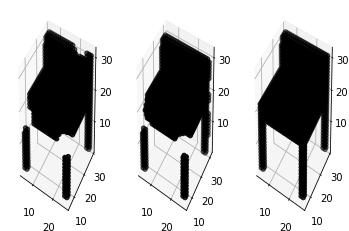

In [ ]:
train(last_step=6344, last_epoch=120)

In [ ]:
train(last_step=9985, last_epoch=190)

  0%|          | 0/52 [00:00<?, ?it/s]

Step 10000: 	 Generator loss: 0.029943451642990115, Discriminator loss: 0.014951319634914398
Epoch 191 | Step:10038 	 Generator loss: 0.07391461384296416, Discriminator loss: 0.037077095627784724


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 192 | Step:10090 	 Generator loss: 0.17788437926769257, Discriminator loss: 0.08901256316900254


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 193 | Step:10142 	 Generator loss: 0.28188417685031897, Discriminator loss: 0.1408983591198921


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 194 | Step:10194 	 Generator loss: 0.3858839299678804, Discriminator loss: 0.19277546995878234


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 195 | Step:10246 	 Generator loss: 0.489883884072304, Discriminator loss: 0.24464771306514752


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 196 | Step:10298 	 Generator loss: 0.5938837434053423, Discriminator loss: 0.29651799345016494


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 197 | Step:10350 	 Generator loss: 0.6978828692436222, Discriminator loss: 0.34837907987833044


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 198 | Step:10402 	 Generator loss: 0.8018826982975009, Discriminator loss: 0.4002271649241449


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 199 | Step:10454 	 Generator loss: 0.9058825651407246, Discriminator loss: 0.452073261678219


  0%|          | 0/52 [00:00<?, ?it/s]

Step 10500: 	 Generator loss: 0.9998811281919485, Discriminator loss: 0.4989237047433853
Epoch 200 | Step:10506 	 Generator loss: 0.009999999403953552, Discriminator loss: 0.004983073294162751
disc_20.pth and gen_20.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 201 | Step:10558 	 Generator loss: 0.11399988615512856, Discriminator loss: 0.056804820120334616


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 202 | Step:10610 	 Generator loss: 0.2179997540712358, Discriminator loss: 0.10860812735557555


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 203 | Step:10662 	 Generator loss: 0.32199968373775506, Discriminator loss: 0.16040404343605033


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 204 | Step:10714 	 Generator loss: 0.4259993307590487, Discriminator loss: 0.21217979091405864


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 205 | Step:10766 	 Generator loss: 0.529999250173569, Discriminator loss: 0.26395086461305617


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 206 | Step:10818 	 Generator loss: 0.6339991075992587, Discriminator loss: 0.3157211324572564


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 207 | Step:10870 	 Generator loss: 0.7379990460872653, Discriminator loss: 0.3674898145198821


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 208 | Step:10922 	 Generator loss: 0.8419949014186862, Discriminator loss: 0.419236482322216


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 209 | Step:10974 	 Generator loss: 0.9457215892076497, Discriminator loss: 0.46613327914476393


  0%|          | 0/52 [00:00<?, ?it/s]

Step 11000: 	 Generator loss: 0.9909860830307012, Discriminator loss: 0.4893214577436449
Epoch 210 | Step:11026 	 Generator loss: 0.03885009038448333, Discriminator loss: 0.020895927131175995
disc_21.pth and gen_21.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 211 | Step:11078 	 Generator loss: 0.11904698967933657, Discriminator loss: 0.06420125794410704


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 212 | Step:11130 	 Generator loss: 0.1969502580165863, Discriminator loss: 0.10754350686073305


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 213 | Step:11182 	 Generator loss: 0.2802257389426231, Discriminator loss: 0.1526659545302391


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 214 | Step:11234 	 Generator loss: 0.38419022077321996, Discriminator loss: 0.20454926377534863


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 215 | Step:11286 	 Generator loss: 0.4881526152491569, Discriminator loss: 0.25639785951375965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 216 | Step:11338 	 Generator loss: 0.5920142412781716, Discriminator loss: 0.308315119981766


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 217 | Step:11390 	 Generator loss: 0.6959374372363094, Discriminator loss: 0.360289800643921


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 218 | Step:11442 	 Generator loss: 0.7998408980965621, Discriminator loss: 0.4122652242183687


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 219 | Step:11494 	 Generator loss: 0.9037427089810375, Discriminator loss: 0.4642462525963785


  0%|          | 0/52 [00:00<?, ?it/s]

Step 11500: 	 Generator loss: 0.9177300564646725, Discriminator loss: 0.47124378031492253
Epoch 220 | Step:11546 	 Generator loss: 0.08991159296035767, Discriminator loss: 0.044988349378108985
disc_22.pth and gen_22.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 221 | Step:11598 	 Generator loss: 0.19383704245090483, Discriminator loss: 0.09700270217657092


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 222 | Step:11650 	 Generator loss: 0.29781783688068375, Discriminator loss: 0.14899757450819015


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 223 | Step:11702 	 Generator loss: 0.4018020466566085, Discriminator loss: 0.2009898869991302


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 224 | Step:11754 	 Generator loss: 0.5057843191623684, Discriminator loss: 0.25298406821489333


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 225 | Step:11806 	 Generator loss: 0.6097662482261655, Discriminator loss: 0.30497875303030003


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 226 | Step:11858 	 Generator loss: 0.7137480881214137, Discriminator loss: 0.35697341173887254


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 227 | Step:11910 	 Generator loss: 0.8177299710512156, Discriminator loss: 0.4089680624604226


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 228 | Step:11962 	 Generator loss: 0.921712026715278, Discriminator loss: 0.4609626948833467


  0%|          | 0/52 [00:00<?, ?it/s]

Step 12000: 	 Generator loss: 0.9996986138820639, Discriminator loss: 0.49995867550373096
Epoch 229 | Step:12014 	 Generator loss: 0.02599551975727081, Discriminator loss: 0.012998573005199434


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 230 | Step:12066 	 Generator loss: 0.12997804975509647, Discriminator loss: 0.06499302625656128
disc_23.pth and gen_23.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 231 | Step:12118 	 Generator loss: 0.23396012449264525, Discriminator loss: 0.1169873778820038


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 232 | Step:12170 	 Generator loss: 0.33794257056713106, Discriminator loss: 0.1689816150069237


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 233 | Step:12222 	 Generator loss: 0.44192519366741173, Discriminator loss: 0.2209757478833199


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 234 | Step:12274 	 Generator loss: 0.5459079439640044, Discriminator loss: 0.27296976786851895


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 235 | Step:12326 	 Generator loss: 0.649890540599823, Discriminator loss: 0.3249637005329134


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 236 | Step:12378 	 Generator loss: 0.7538731524944307, Discriminator loss: 0.37695743334293375


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 237 | Step:12430 	 Generator loss: 0.8578355122804642, Discriminator loss: 0.42894866615533844


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 238 | Step:12482 	 Generator loss: 0.9617971330881113, Discriminator loss: 0.4809398892521861


  0%|          | 0/52 [00:00<?, ?it/s]

Step 12500: 	 Generator loss: 0.9997847166061395, Discriminator loss: 0.4999376120567325
Epoch 239 | Step:12534 	 Generator loss: 0.06597675180435181, Discriminator loss: 0.032994171142578126


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 240 | Step:12586 	 Generator loss: 0.16994086790084836, Discriminator loss: 0.0849827600121498
disc_24.pth and gen_24.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 241 | Step:12638 	 Generator loss: 0.27390501761436453, Discriminator loss: 0.1369712389707565


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 242 | Step:12690 	 Generator loss: 0.37786990535259224, Discriminator loss: 0.1889594179987907


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 243 | Step:12742 	 Generator loss: 0.4818354094028469, Discriminator loss: 0.24094724297523507


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 244 | Step:12794 	 Generator loss: 0.5858010878562928, Discriminator loss: 0.29293479460477845


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 245 | Step:12846 	 Generator loss: 0.6897669780254364, Discriminator loss: 0.34492209213972097


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 246 | Step:12898 	 Generator loss: 0.7937331302165982, Discriminator loss: 0.39690919172763833


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 247 | Step:12950 	 Generator loss: 0.8976998643875119, Discriminator loss: 0.44889605122804654


  0%|          | 0/52 [00:00<?, ?it/s]

Step 13000: 	 Generator loss: 0.9996674730777734, Discriminator loss: 0.49988296484947203
Epoch 248 | Step:13002 	 Generator loss: 0.0019992464780807496, Discriminator loss: 0.0009998157024383545


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 249 | Step:13054 	 Generator loss: 0.1059662923812866, Discriminator loss: 0.05298633295297623


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 250 | Step:13106 	 Generator loss: 0.20993386542797088, Discriminator loss: 0.10497275799512859
disc_25.pth and gen_25.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 251 | Step:13158 	 Generator loss: 0.31390137004852287, Discriminator loss: 0.15695922482013702


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 252 | Step:13210 	 Generator loss: 0.4178683478832241, Discriminator loss: 0.20894600033760063


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 253 | Step:13262 	 Generator loss: 0.5218360443115231, Discriminator loss: 0.2609326773285865


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 254 | Step:13314 	 Generator loss: 0.6258047816753384, Discriminator loss: 0.31291886657476425


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 255 | Step:13366 	 Generator loss: 0.7297733833789826, Discriminator loss: 0.36490491211414333


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 256 | Step:13418 	 Generator loss: 0.8337427648305896, Discriminator loss: 0.41689085906744006


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 257 | Step:13470 	 Generator loss: 0.9377121002674107, Discriminator loss: 0.4688766906857493


  0%|          | 0/52 [00:00<?, ?it/s]

Step 13500: 	 Generator loss: 0.9996941593885424, Discriminator loss: 0.49986817264556915
Epoch 258 | Step:13522 	 Generator loss: 0.04198740828037263, Discriminator loss: 0.0209941885471344


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 259 | Step:13574 	 Generator loss: 0.1459565660953522, Discriminator loss: 0.07297975498437882


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 260 | Step:13626 	 Generator loss: 0.24992596161365513, Discriminator loss: 0.12496533626317978
disc_26.pth and gen_26.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 261 | Step:13678 	 Generator loss: 0.353895165324211, Discriminator loss: 0.17695089054107666


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 262 | Step:13730 	 Generator loss: 0.45786454880237565, Discriminator loss: 0.22893643683195103


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 263 | Step:13782 	 Generator loss: 0.5618341505527495, Discriminator loss: 0.28092204535007453


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 264 | Step:13834 	 Generator loss: 0.6658034950494766, Discriminator loss: 0.3329076074361799


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 265 | Step:13886 	 Generator loss: 0.7697733205556868, Discriminator loss: 0.38489313733577724


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 266 | Step:13938 	 Generator loss: 0.8737427788972855, Discriminator loss: 0.43687865251302704


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 267 | Step:13990 	 Generator loss: 0.9777122316360473, Discriminator loss: 0.4888639584779738


  0%|          | 0/52 [00:00<?, ?it/s]

Step 14000: 	 Generator loss: 0.9997058131694793, Discriminator loss: 0.4998609290122985
Epoch 268 | Step:14042 	 Generator loss: 0.08197621393203734, Discriminator loss: 0.04098836117982865


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 269 | Step:14094 	 Generator loss: 0.185946115732193, Discriminator loss: 0.09297367459535599


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 270 | Step:14146 	 Generator loss: 0.2899157555103301, Discriminator loss: 0.14495884764194494
disc_27.pth and gen_27.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 271 | Step:14198 	 Generator loss: 0.3938859167099, Discriminator loss: 0.19694405484199534


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 272 | Step:14250 	 Generator loss: 0.4978555965423584, Discriminator loss: 0.24892921310663232


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 273 | Step:14302 	 Generator loss: 0.6018254830837251, Discriminator loss: 0.3009143471121786


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 274 | Step:14354 	 Generator loss: 0.705794907927513, Discriminator loss: 0.35289947736263244


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 275 | Step:14406 	 Generator loss: 0.8097646429538727, Discriminator loss: 0.4048845270872111


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 276 | Step:14458 	 Generator loss: 0.9137339264154433, Discriminator loss: 0.4568695672750469


  0%|          | 0/52 [00:00<?, ?it/s]

Step 14500: 	 Generator loss: 0.9997085694074628, Discriminator loss: 0.49985718250274624
Epoch 277 | Step:14510 	 Generator loss: 0.01799470472335815, Discriminator loss: 0.00899743366241455


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 278 | Step:14562 	 Generator loss: 0.12196442079544068, Discriminator loss: 0.06098247587680817


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 279 | Step:14614 	 Generator loss: 0.2259338558912277, Discriminator loss: 0.11296752858161929


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 280 | Step:14666 	 Generator loss: 0.32990322959423046, Discriminator loss: 0.16495259815454494
disc_28.pth and gen_28.pth were saved.


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 281 | Step:14718 	 Generator loss: 0.4338724168539046, Discriminator loss: 0.21693766915798213


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 282 | Step:14770 	 Generator loss: 0.5378414964675902, Discriminator loss: 0.2689227448701862


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 283 | Step:14822 	 Generator loss: 0.6418109335899351, Discriminator loss: 0.32090787214040783


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 284 | Step:14874 	 Generator loss: 0.7457800738811486, Discriminator loss: 0.3728929666280749


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 285 | Step:14926 	 Generator loss: 0.8497495105266566, Discriminator loss: 0.4248780542016033


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 286 | Step:14978 	 Generator loss: 0.953718873739242, Discriminator loss: 0.4768632156252864


  0%|          | 0/52 [00:00<?, ?it/s]

Step 15000: 	 Generator loss: 0.9997052778005596, Discriminator loss: 0.4998563179969792
Epoch 287 | Step:15030 	 Generator loss: 0.057982819199562066, Discriminator loss: 0.028992050409317016


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 288 | Step:15082 	 Generator loss: 0.1619518628120422, Discriminator loss: 0.08097721499204635


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 289 | Step:15134 	 Generator loss: 0.265920715212822, Discriminator loss: 0.13296238940954205


  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
save_model('last')

In [ ]:
# limpiar memoria
# with torch.no_grad():
#   torch.cuda.empty_cache()

# Testing

In [20]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true -O broken_chair.npy

--2022-11-23 17:08:24--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy [following]
--2022-11-23 17:08:25--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy [following]
--2022-11-23 17:08:25--  https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185

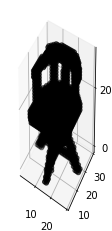

In [23]:
filename = 'broken_chair.npy' #@param {type:'string'}
array = np.load(filename)
showArr3DBoolC(array)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
array_t = torch.from_numpy( array.reshape(1,1, 32,32,32) ).float().to(device)
array_t.shape

torch.Size([1, 1, 32, 32, 32])

In [27]:
def get_patch(obj:torch.Tensor, filled:torch.Tensor):
  patch = filled.round() - obj
  return patch

In [49]:
last_n_saved = "24" #@param {type:'string'}
#folder = '/content' #@param {type:'string'}
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen2 = load_model(last_n_saved, 'gen').to(device)
generated = gen2(array_t)
patch = get_patch(array_t, generated)

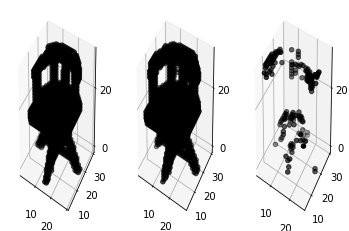

In [50]:
show_tensor_images(array_t, (32,32,32), 1, num_images=1)
show_tensor_images(generated, (32,32,32), 2, num_images=1)
show_tensor_images(patch, (32,32,32), 3, num_images=1)

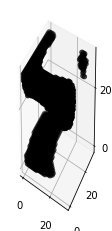

In [ ]:
generated = gen2(array_t)
show_tensor_images(generated, (32,32,32), 1, num_images=1)